# Покупки в онлайн магазине. Расчет бизнес-метрик (MAU, WAU, DAU). Retantion rate через Когортный анализ.

# Описание располагаемых данных

Имеются три датасета:
- `visits_log.csv` -- информация о посещениях сайта;
- `orders_log.csv` — информация о заказах;
- `costs.csv` — информация о расходах на маркетинг.

**Структура `visits_log.csv`**

|Имя поля| Описание поля|
|---:|:---|
|Uid | уникальный идентификатор пользователя|
|Device | категория устройства пользователя|
|Start Ts | дата и время начала сессии|
|End Ts | дата и время окончания сессии|
|Source Id | идентификатор источника перехода на сайт|

**Структура `orders_log.csv`**

|Имя поля| Описание поля|
|---:|:---|
|Uid | уникальный идентификатор пользователя|
|Buy Ts | дата и время заказа|
|Revenue | сумма заказа|

**Структура `costs.csv`**

|Имя поля| Описание поля|
|---:|:---|
|source_id | идентификатор рекламного источника|
|dt | дата проведения рекламной кампании|
|costs | расходы на эту кампанию|

**Шаг 1. Загрузить данные и подготовить их к анализу**

**Шаг 2. Рассчитать метрики и построить графики**

1. Рассчитать DAU, WAU и MAU. Отобразить изменения метрик на графиках;
2. Определить, сколько раз за день пользователи в среднем заходят на сайт. Построить график, отражающий изменения метрики во времени;
3. Исследовать, сколько времени пользователи проводят на сайте. Узнать продолжительность типичной пользовательской сессии за весь период.
4. Рассчитать Retention Rate, применяя когортный анализ. Показать изменения метрики во времени на графике.



In [36]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
from glob import glob
glob('*.csv')

['visits.csv', 'costs.csv', 'orders.csv']

In [38]:
lst_df = []
for path_file in glob('*.csv'):
    lst_df.append(pd.read_csv(path_file))

In [39]:
for df in lst_df:
    display(df.head(2))
    print()
    display(df.info())
    print(f'-'*10)

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


None

----------


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


None

----------


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


None

----------


## Преобработка данных

In [40]:
#корректировка заголовков
for df in lst_df:
    print(df.columns)

Index(['Device', 'End Ts', 'Source Id', 'Start Ts', 'Uid'], dtype='object')
Index(['source_id', 'dt', 'costs'], dtype='object')
Index(['Buy Ts', 'Revenue', 'Uid'], dtype='object')


In [41]:
#убираем верхний регистр и вместо пробелов ставим нижнее подчеркивание
for df in lst_df:
    df.columns = ['_'.join(col_name.lower().split()) for col_name in df.columns]

for df in lst_df:
  print(df.columns)

Index(['device', 'end_ts', 'source_id', 'start_ts', 'uid'], dtype='object')
Index(['source_id', 'dt', 'costs'], dtype='object')
Index(['buy_ts', 'revenue', 'uid'], dtype='object')


In [42]:
# корректировка типов данных
for index, df in enumerate(lst_df):
    for col in df.select_dtypes('object').columns:
        lst_df[index][col] = df[col].astype('datetime64[s]', errors='ignore')

lst_df[2].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype        
---  ------   --------------  -----        
 0   buy_ts   50415 non-null  datetime64[s]
 1   revenue  50415 non-null  float64      
 2   uid      50415 non-null  uint64       
dtypes: datetime64[s](1), float64(1), uint64(1)
memory usage: 1.2 MB


In [43]:
for df in lst_df:
    print(df.duplicated().sum())

    #дублей нет

0
0
0


In [44]:
df_visits, df_costs, df_orders = lst_df
df_visits.columns

Index(['device', 'end_ts', 'source_id', 'start_ts', 'uid'], dtype='object')

In [45]:
#аномалии
# период проведения рекламной компании
date_min, date_max = df_costs['dt'].agg(['min', 'max']).to_list()
print(date_min, date_max)

2017-06-01 00:00:00 2018-05-31 00:00:00


In [46]:
#рассмотрим случаи когда сессия проходит не во временных рамках рекламной компании

# клиенты, которые начали сессию во время рк, а закончили после - аномаль
df_visits.loc[df_visits.end_ts.dt.date > date_max.date()]

# клиенты, которые начали сессию до начала рк, а закончили во время  - аномаль
df_visits.loc[df_visits.end_ts.dt.date < date_min.date()]

# клиенты, которые покупали до начала рк - аномаль
df_orders.loc[df_orders.buy_ts.dt.date < date_min.date()]

# клиенты, которые покупали после окончания рк - аномаль
df_orders.loc[df_orders.buy_ts.dt.date > date_max.date()]

#клиентов с покупкой не много, всего один, поэтому его данные не повлияют на эффективность, удалять не будем
#может повлиять в когортном анализе, но пока трогать не будем

,buy_ts,revenue,uid
50414,2018-06-01 00:02:00,3.42,83872787173869366


In [47]:
# для каждого клиента посчитаем количество посещений и покупок

df_l = df_visits.groupby('uid')\
         .agg(count_visits_users=('uid', 'count'),
              first_date_visits=('start_ts', 'min'),
              last_date_visits=('end_ts', 'max'))\
         .sort_values(by='count_visits_users', ascending=False)\
         .reset_index()
df_l

df_r = df_orders.groupby('uid')\
         .agg(count_bye=('uid', 'count'))\
         .sort_values(by='count_bye', ascending=False)\
         .reset_index()

df_total=df_l.merge(df_r, on='uid', how='left')

In [48]:
print( df_total.isna().sum(), df_total.shape[0])
#191646 клиентов из 228169 ничего не купили!!!

uid                        0
count_visits_users         0
first_date_visits          0
last_date_visits           0
count_bye             191646
dtype: int64 228169


## 2.1. Продуктовые метрики

Рассчитаем DAU, WAU и MAU

In [49]:
# для признака `start_ts` выделим день, неделю и месяц визита клиента

df_visits['visit_day'] = df_visits['start_ts'].dt.date
df_visits['visit_week'] = df_visits['start_ts'].dt.isocalendar().week
df_visits['visit_month'] = df_visits['start_ts'].dt.strftime("%Y-%m")

df_visits['visit_year'] = df_visits['start_ts'].dt.year

df_visits[['start_ts', 'visit_day', 'visit_month', 'visit_week', 'visit_year']]

,start_ts,visit_day,visit_month,visit_week,visit_year
0,2017-12-20 17:20:00,2017-12-20,2017-12,51,2017
1,2018-02-19 16:53:00,2018-02-19,2018-02,8,2018
2,2017-07-01 01:54:00,2017-07-01,2017-07,26,2017
3,2018-05-20 10:59:00,2018-05-20,2018-05,20,2018
4,2017-12-27 14:06:00,2017-12-27,2017-12,52,2017
...,...,...,...,...,...
359395,2017-07-29 19:07:00,2017-07-29,2017-07,30,2017
359396,2018-01-25 17:38:00,2018-01-25,2018-01,4,2018
359397,2018-03-03 10:12:00,2018-03-03,2018-03,9,2018
359398,2017-11-02 10:12:00,2017-11-02,2017-11,44,2017


dau:
            visit_day  dau_value
0    2017-06-01        605
1    2017-06-02        608
2    2017-06-03        445
3    2017-06-04        476
4    2017-06-05        820
..          ...        ...
359  2018-05-27        620
360  2018-05-28       1039
361  2018-05-29        948
362  2018-05-30       1289
363  2018-05-31       1997

[364 rows x 2 columns] 


<ipython-input-50-8594e6f17542>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),


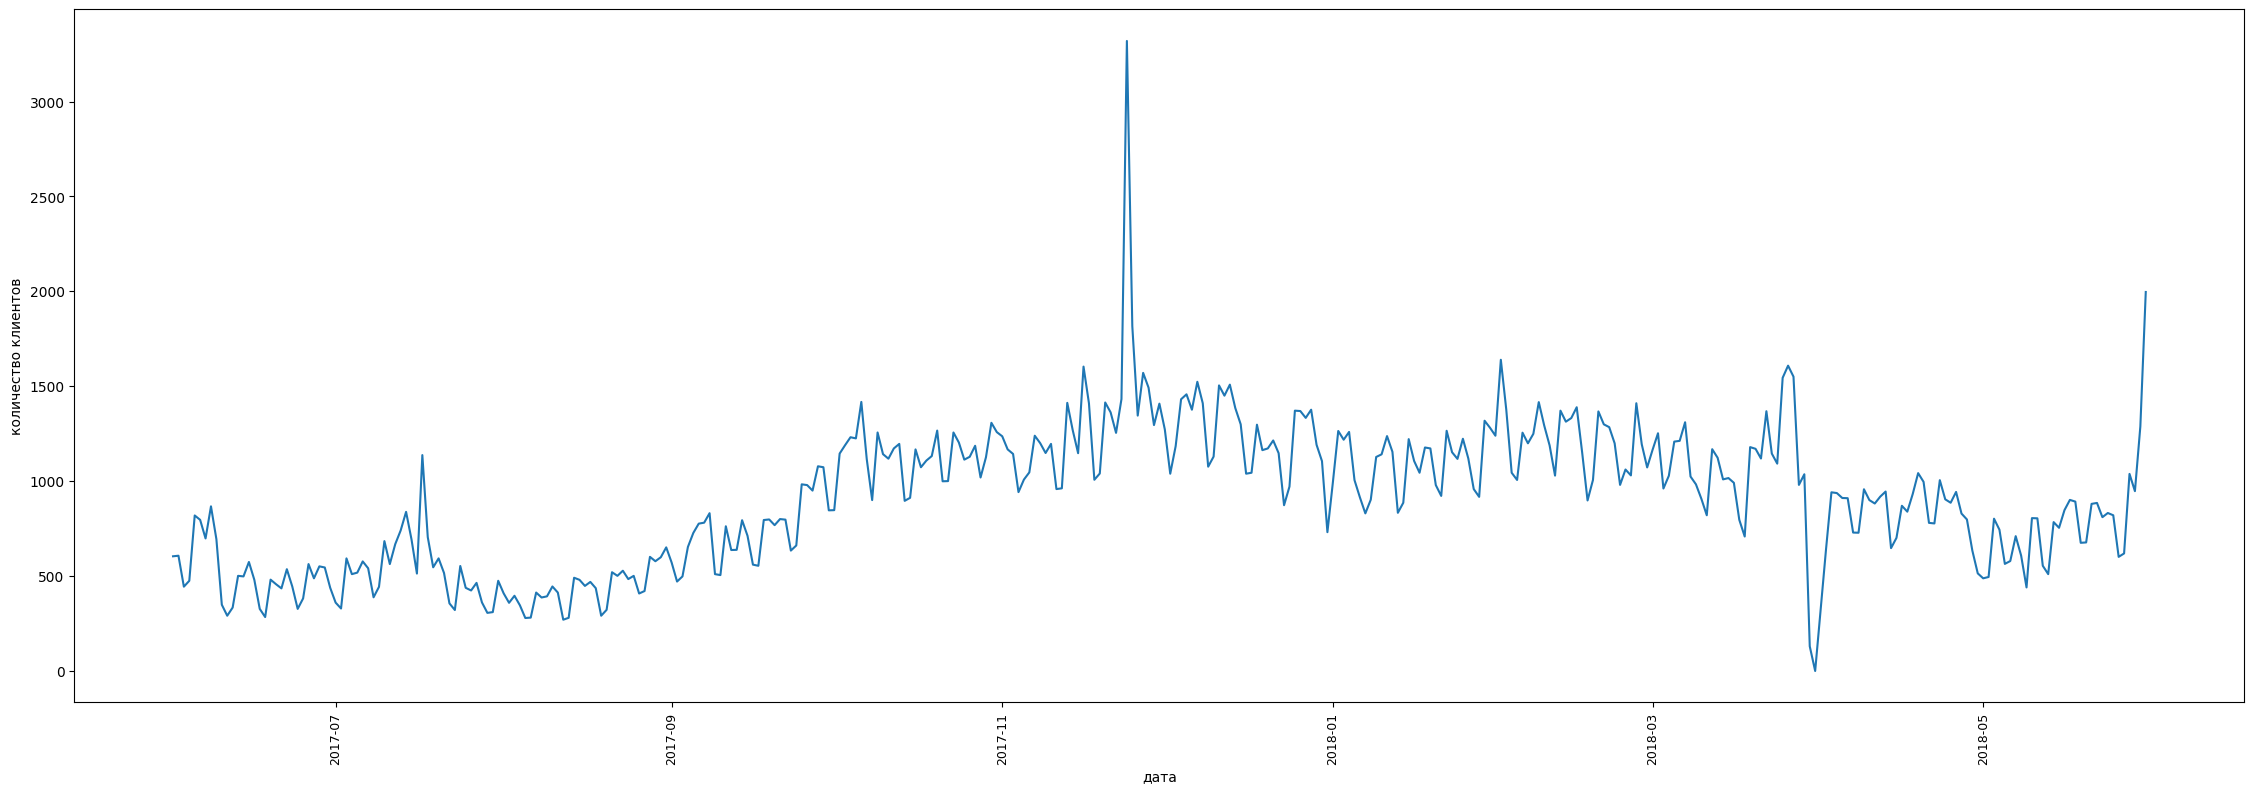

In [50]:
# dau
dau = df_visits.groupby('visit_day')\
               .agg(dau_value=('uid', 'nunique'))\
               .reset_index()


print(f'''dau:
      {dau} ''')

plt.figure(figsize=(28,9))
ax = sns.lineplot(data=dau,
                  x='visit_day',
                  y='dau_value'
                  )
ax.set_xlabel('дата')
ax.set_ylabel('количество клиентов')
ax.set_xticklabels(ax.get_xticklabels(),
                    fontsize=9,
                    rotation=90);

In [51]:
#wau

wau = df_visits.groupby(['visit_year', 'visit_week'])\
               .agg(wau_value=('uid', 'nunique'))\
               .reset_index()

print(f'''wau:
      {wau} ''')


wau:
          visit_year  visit_week  wau_value
0         2017          22       2021
1         2017          23       4129
2         2017          24       2812
3         2017          25       2878
4         2017          26       3064
5         2017          27       3294
6         2017          28       4355
7         2017          29       3841
8         2017          30       2655
9         2017          31       2364
10        2017          32       2444
11        2017          33       2746
12        2017          34       3116
13        2017          35       3694
14        2017          36       4412
15        2017          37       4319
16        2017          38       4874
17        2017          39       6241
18        2017          40       7612
19        2017          41       7074
20        2017          42       7148
21        2017          43       7401
22        2017          44       7480
23        2017          45       7179
24        2017          46       8117
2

<ipython-input-52-9ad89c133c68>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),


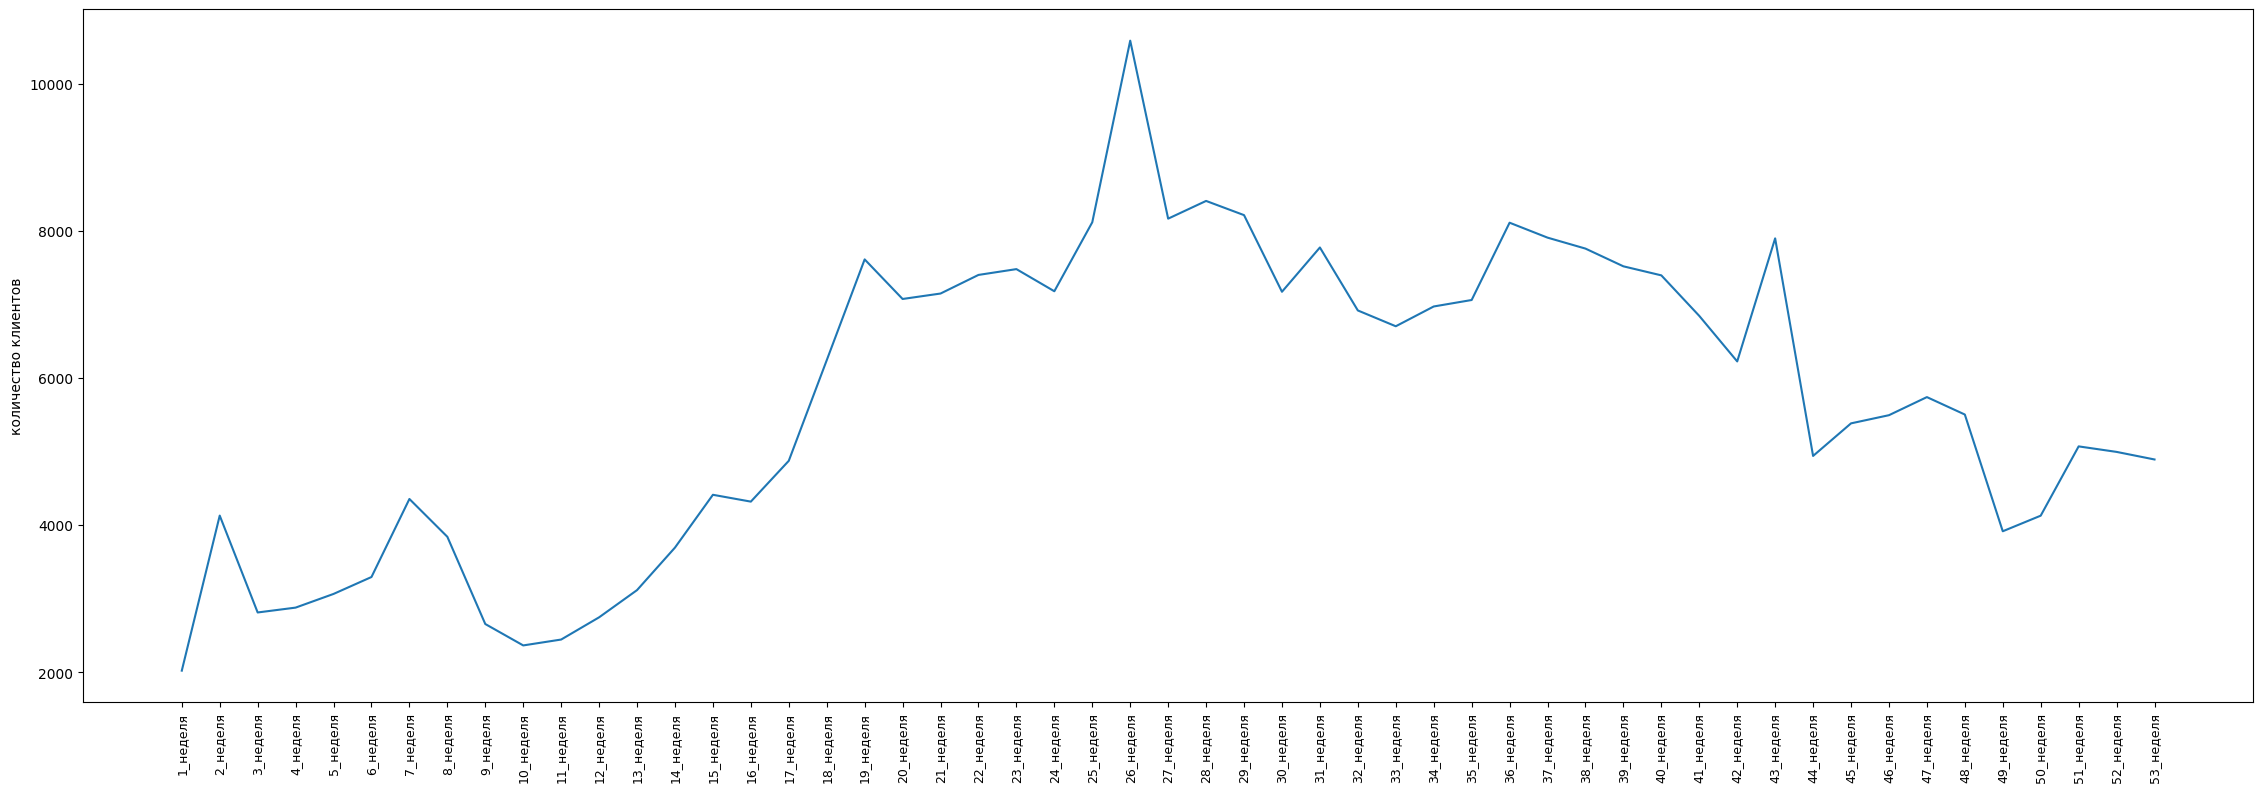

In [52]:
x_date=[str(number)+'_неделя' for number in range(1,54)]
plt.figure(figsize=(28,9))
ax = sns.lineplot(data=wau,
                  x=x_date,
                  y='wau_value'
                  )
ax.set_ylabel('количество клиентов')
ax.set_xticklabels(ax.get_xticklabels(),
                    fontsize=9,
                    rotation=90);

<ipython-input-53-6fec00288ca2>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),


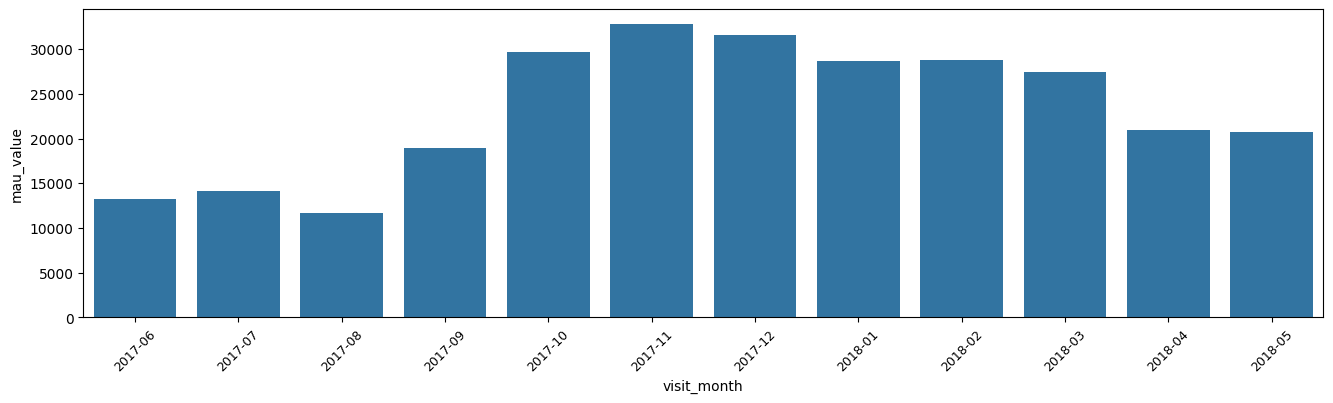

In [53]:
#mau

mau = df_visits.groupby('visit_month')\
               .agg(mau_value=('uid', 'nunique'))\
               .reset_index()

mau
plt.figure(figsize=(16,4))
ax=sns.barplot(data=mau,
            x='visit_month',
            y='mau_value')
ax.set_xticklabels(ax.get_xticklabels(),
                    fontsize=9,
                    rotation=45);

Определить, сколько раз за день пользователи в среднем заходят на сайт. Построить график, отражающий изменения метрики во времени

In [54]:
#считаем кол-во посещений/количество уникальных пользователей
df_mean_visits = df_visits.groupby('visit_day')\
                          .agg(count_visits=('uid', 'count'),
                               count_users=('uid', 'nunique'))\
                          .reset_index()
df_mean_visits['mean_count_visits'] = (df_mean_visits["count_visits"] / df_mean_visits["count_users"]).round(4)
df_mean_visits

,visit_day,count_visits,count_users,mean_count_visits
0,2017-06-01,664,605,1.0975
1,2017-06-02,658,608,1.0822
2,2017-06-03,477,445,1.0719
3,2017-06-04,510,476,1.0714
4,2017-06-05,893,820,1.0890
...,...,...,...,...
359,2018-05-27,672,620,1.0839
360,2018-05-28,1156,1039,1.1126
361,2018-05-29,1035,948,1.0918
362,2018-05-30,1410,1289,1.0939


<Axes: xlabel='visit_day', ylabel='mean_count_visits'>

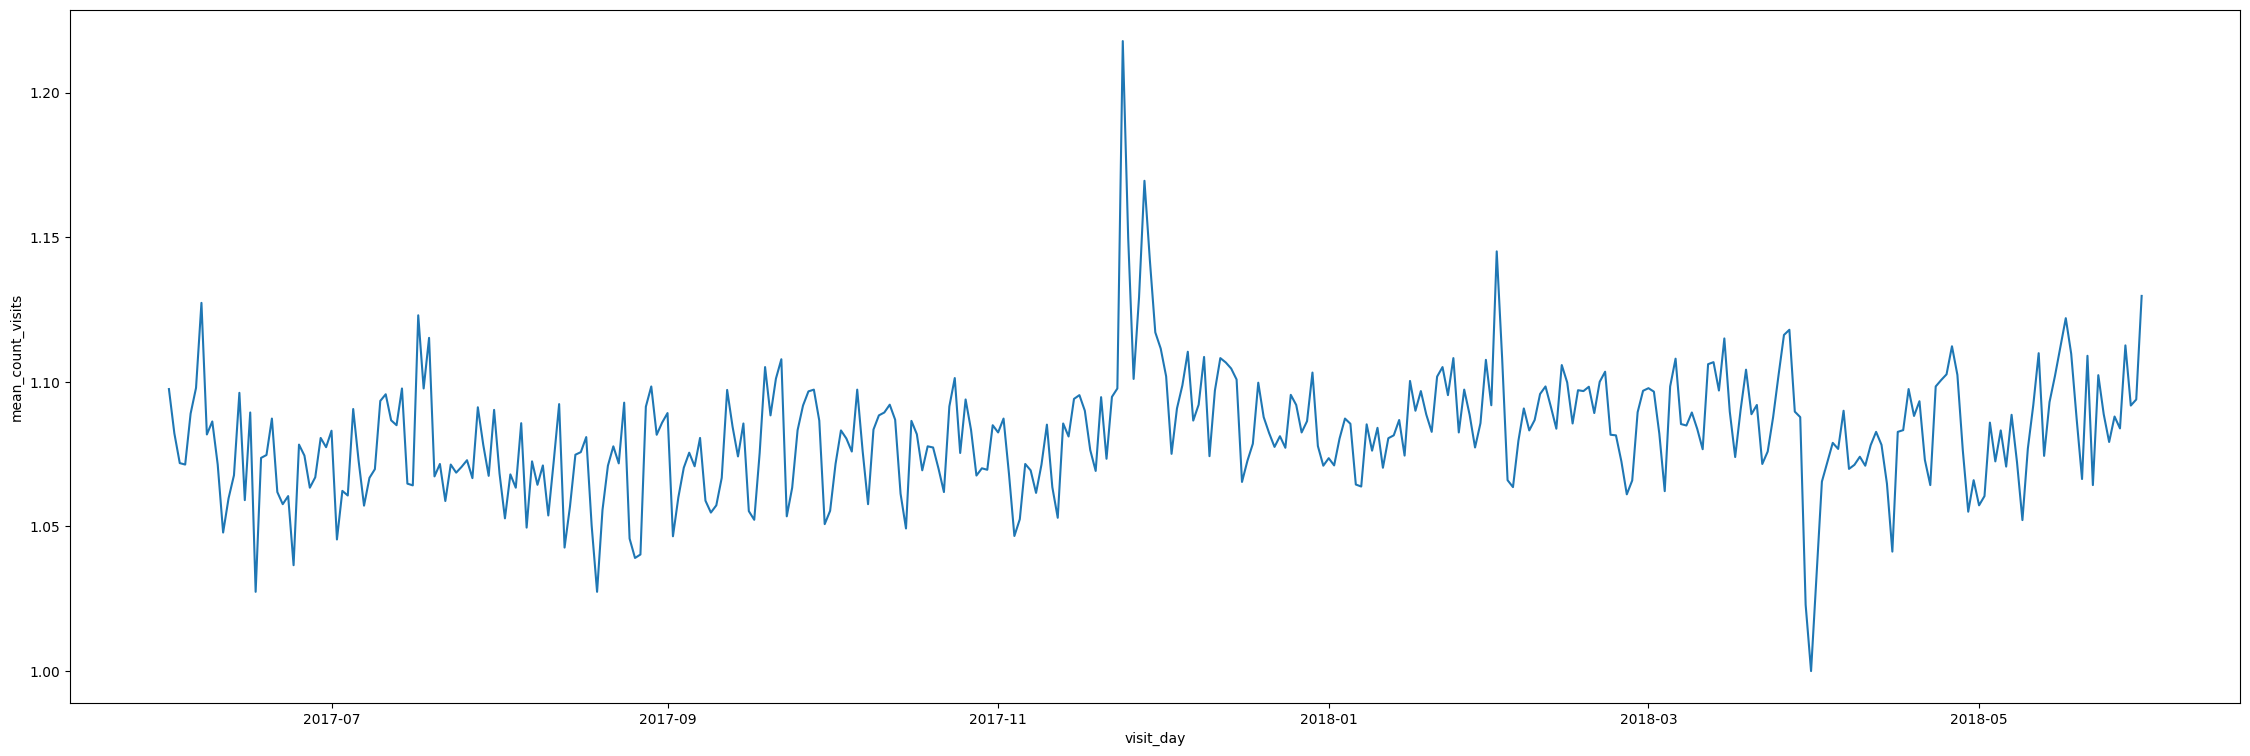

In [55]:
plt.figure(figsize=(28,9))
sns.lineplot(data=df_mean_visits,
            x="visit_day",
            y="mean_count_visits")

**Вывод: в среднем каждый пользователь заходит 1 раз в день**

Исследовать, сколько времени пользователи проводят на сайте. Узнать продолжительность типичной пользовательской сессии за весь период.

In [56]:
# считаем продолжительность сессии  end_ts - start_ts, нормируем на минуту

df_visits["duration_session"] = (df_visits["end_ts"] - df_visits["start_ts"]) / np.timedelta64(1, "m")
df_visits[["end_ts", "start_ts", "duration_session"]]
df_visits['duration_session'].value_counts()

,count
duration_session,
1.0,53029
0.0,35794
2.0,35748
3.0,26672
4.0,21085
...,...
297.0,1
308.0,1
239.0,1


In [57]:
#проверим на аномальные значения

df_visits['duration_session'].describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])



,duration_session
count,359400.000000
mean,10.717095
std,16.618796
min,-46.000000
1%,0.000000
5%,0.000000
25%,2.000000
50%,5.000000
75%,14.000000
95%,38.000000


In [58]:
#отфильтруем аномальные значения, удалим все что больше 75мин и аномально короткие
np.percentile(df_visits["duration_session"], 99)
flt_visits = df_visits["duration_session"].between(0.00001,
                                      np.percentile(df_visits["duration_session"], 99))

print(f"Процент потерь {(1 - df_visits.loc[flt_visits].shape[0] / df_visits.shape[0]):.2%}")


Процент потерь 10.93%


In [59]:
index_delete = set(df_visits.index).difference(set(df_visits.loc[flt_visits].index))

df_visits.drop(index=index_delete, inplace=True)

<Axes: xlabel='duration_session', ylabel='Count'>

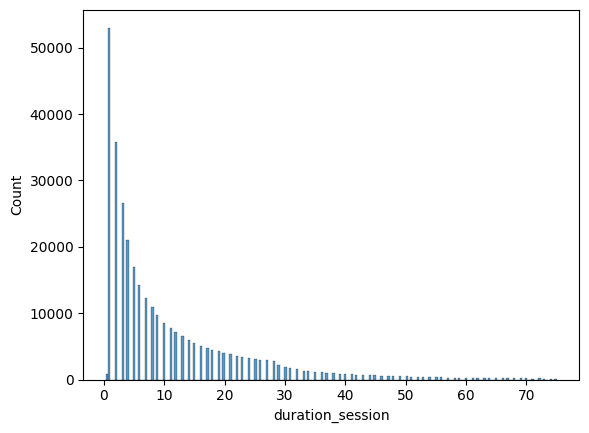

In [60]:
# строим график
sns.histplot(data=df_visits,
            x='duration_session')

Рассчет Retention Rate, применяя когортный анализ

In [61]:
# выделим данные для подсчета RR в отдельный набор

df = df_visits[["end_ts", "start_ts", "uid"]]

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 320107 entries, 0 to 359399
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype        
---  ------    --------------   -----        
 0   end_ts    320107 non-null  datetime64[s]
 1   start_ts  320107 non-null  datetime64[s]
 2   uid       320107 non-null  uint64       
dtypes: datetime64[s](2), uint64(1)
memory usage: 9.8 MB


In [63]:
# для каждого клиента найдем дату первого посещения
df_r = df.groupby("uid")\
         .agg(firts_visit_time=('start_ts', 'min'))\
         .reset_index()
print(df_r)
# подклеим время первого посещения в основной набор данных
df = df.merge(df_r,
         on="uid")
df

                         uid    firts_visit_time
0             11863502262781 2018-03-01 17:27:00
1             49537067089222 2018-02-06 15:55:00
2            297729379853735 2017-06-07 18:47:00
3            313578113262317 2017-09-18 22:49:00
4            325320750514679 2017-09-30 14:29:00
...                      ...                 ...
206497  18446316582013423015 2018-02-26 10:14:00
206498  18446403737806311543 2017-11-30 03:36:00
206499  18446556406699109058 2018-01-01 16:29:00
206500  18446621818809592527 2017-12-27 13:27:00
206501  18446676030785672386 2017-10-04 16:01:00

[206502 rows x 2 columns]


,end_ts,start_ts,uid,firts_visit_time
0,2017-12-20 17:38:00,2017-12-20 17:20:00,16879256277535980062,2017-12-20 17:20:00
1,2018-02-19 17:21:00,2018-02-19 16:53:00,104060357244891740,2018-02-19 16:53:00
2,2018-05-20 11:23:00,2018-05-20 10:59:00,16174680259334210214,2018-03-09 20:05:00
3,2017-09-03 21:36:00,2017-09-03 21:35:00,16007536194108375387,2017-09-03 21:35:00
4,2018-01-30 12:09:00,2018-01-30 11:13:00,6661610529277171451,2017-06-29 09:00:00
...,...,...,...,...
320102,2017-07-29 19:07:19,2017-07-29 19:07:00,18363291481961487539,2017-07-29 19:07:00
320103,2018-01-25 17:38:19,2018-01-25 17:38:00,18370831553019119586,2018-01-25 17:38:00
320104,2018-03-03 10:12:19,2018-03-03 10:12:00,18387297585500748294,2018-03-03 10:12:00
320105,2017-11-02 10:12:19,2017-11-02 10:12:00,18388616944624776485,2017-11-02 10:12:00


In [64]:
#контрольный клиент
df[df.uid==12869801667763685675]

,end_ts,start_ts,uid,firts_visit_time
160,2017-12-13 15:12:00,2017-12-13 15:08:00,12869801667763685675,2017-06-13 11:17:00
395,2017-11-17 12:43:00,2017-11-17 12:42:00,12869801667763685675,2017-06-13 11:17:00
1982,2018-03-05 16:14:00,2018-03-05 16:01:00,12869801667763685675,2017-06-13 11:17:00
2536,2018-02-19 18:35:00,2018-02-19 18:31:00,12869801667763685675,2017-06-13 11:17:00
2741,2018-01-22 16:42:00,2018-01-22 16:39:00,12869801667763685675,2017-06-13 11:17:00
...,...,...,...,...
317694,2018-03-17 17:26:00,2018-03-17 17:20:00,12869801667763685675,2017-06-13 11:17:00
317830,2018-04-16 09:55:00,2018-04-16 09:46:00,12869801667763685675,2017-06-13 11:17:00
318473,2018-02-10 13:51:00,2018-02-10 13:07:00,12869801667763685675,2017-06-13 11:17:00
318476,2017-10-15 13:59:00,2017-10-15 13:35:00,12869801667763685675,2017-06-13 11:17:00


In [65]:
# для каждого клиента раcсчитаем его периоды активности

df['cohort_lifetime'] = df['start_ts'].dt.to_period('M').astype(int) - df['firts_visit_time'].dt.to_period('M').astype('int64')

df

,end_ts,start_ts,uid,firts_visit_time,cohort_lifetime
0,2017-12-20 17:38:00,2017-12-20 17:20:00,16879256277535980062,2017-12-20 17:20:00,0
1,2018-02-19 17:21:00,2018-02-19 16:53:00,104060357244891740,2018-02-19 16:53:00,0
2,2018-05-20 11:23:00,2018-05-20 10:59:00,16174680259334210214,2018-03-09 20:05:00,2
3,2017-09-03 21:36:00,2017-09-03 21:35:00,16007536194108375387,2017-09-03 21:35:00,0
4,2018-01-30 12:09:00,2018-01-30 11:13:00,6661610529277171451,2017-06-29 09:00:00,7
...,...,...,...,...,...
320102,2017-07-29 19:07:19,2017-07-29 19:07:00,18363291481961487539,2017-07-29 19:07:00,0
320103,2018-01-25 17:38:19,2018-01-25 17:38:00,18370831553019119586,2018-01-25 17:38:00,0
320104,2018-03-03 10:12:19,2018-03-03 10:12:00,18387297585500748294,2018-03-03 10:12:00,0
320105,2017-11-02 10:12:19,2017-11-02 10:12:00,18388616944624776485,2017-11-02 10:12:00,0


In [66]:
# сформируем имя которты

df["cohort_name"] = df["firts_visit_time"].dt.strftime("%Y-%m")

df

,end_ts,start_ts,uid,firts_visit_time,cohort_lifetime,cohort_name
0,2017-12-20 17:38:00,2017-12-20 17:20:00,16879256277535980062,2017-12-20 17:20:00,0,2017-12
1,2018-02-19 17:21:00,2018-02-19 16:53:00,104060357244891740,2018-02-19 16:53:00,0,2018-02
2,2018-05-20 11:23:00,2018-05-20 10:59:00,16174680259334210214,2018-03-09 20:05:00,2,2018-03
3,2017-09-03 21:36:00,2017-09-03 21:35:00,16007536194108375387,2017-09-03 21:35:00,0,2017-09
4,2018-01-30 12:09:00,2018-01-30 11:13:00,6661610529277171451,2017-06-29 09:00:00,7,2017-06
...,...,...,...,...,...,...
320102,2017-07-29 19:07:19,2017-07-29 19:07:00,18363291481961487539,2017-07-29 19:07:00,0,2017-07
320103,2018-01-25 17:38:19,2018-01-25 17:38:00,18370831553019119586,2018-01-25 17:38:00,0,2018-01
320104,2018-03-03 10:12:19,2018-03-03 10:12:00,18387297585500748294,2018-03-03 10:12:00,0,2018-03
320105,2017-11-02 10:12:19,2017-11-02 10:12:00,18388616944624776485,2017-11-02 10:12:00,0,2017-11


In [67]:
# для каждой когорты расчитаем и на каждый период жизни рассчитаем количество уникальных клиентов

cohort = df.groupby(['cohort_name', 'cohort_lifetime'])\
           .agg(count_users=('uid', 'nunique'))\
           .reset_index()

cohort

,cohort_name,cohort_lifetime,count_users
0,2017-06,0,11854
1,2017-06,1,898
2,2017-06,2,605
3,2017-06,3,709
4,2017-06,4,772
...,...,...,...
73,2018-03,1,762
74,2018-03,2,475
75,2018-04,0,14187
76,2018-04,1,673


In [68]:
# для каждой когорты рассчитаем количество уникальных клиентов на 0-й период жизни
cohort[cohort.cohort_lifetime == 0]

,cohort_name,cohort_lifetime,count_users
0,2017-06,0,11854
12,2017-07,0,11799
23,2017-08,0,9199
33,2017-09,0,15098
42,2017-10,0,23493
50,2017-11,0,24726
57,2017-12,0,22938
63,2018-01,0,20517
68,2018-02,0,20148
72,2018-03,0,18744


In [69]:
# подклеим полученые данные к когортам
cohort = cohort.merge(cohort[cohort.cohort_lifetime == 0][['cohort_name', 'count_users']],
             on='cohort_name',
             suffixes=["_current", "_initial"])
cohort

,cohort_name,cohort_lifetime,count_users_current,count_users_initial
0,2017-06,0,11854,11854
1,2017-06,1,898,11854
2,2017-06,2,605,11854
3,2017-06,3,709,11854
4,2017-06,4,772,11854
...,...,...,...,...
73,2018-03,1,762,18744
74,2018-03,2,475,18744
75,2018-04,0,14187,14187
76,2018-04,1,673,14187


Retantion Rate

In [70]:
# расчет Retantion Rate

cohort['rr'] = (cohort["count_users_current"] / cohort["count_users_initial"]).round(4)*100

cohort.head(50)

,cohort_name,cohort_lifetime,count_users_current,count_users_initial,rr
0,2017-06,0,11854,11854,100.00
1,2017-06,1,898,11854,7.58
2,2017-06,2,605,11854,5.10
3,2017-06,3,709,11854,5.98
4,2017-06,4,772,11854,6.51
5,2017-06,5,796,11854,6.72
6,2017-06,6,685,11854,5.78
7,2017-06,7,666,11854,5.62
8,2017-06,8,602,11854,5.08
9,2017-06,9,589,11854,4.97


In [74]:
#построим сводную таблицу
rr = cohort.pivot_table(index="cohort_name",
                   columns="cohort_lifetime",
                   values='rr')\
       .fillna(0)
rr

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
cohort_name,,,,,,,,,,,,
2017-06,100.0,7.58,5.10,5.98,6.51,6.72,5.78,5.62,5.08,4.97,3.8,4.39
2017-07,100.0,5.43,5.02,5.54,5.66,4.66,4.41,4.39,3.77,2.73,2.7,0.00
2017-08,100.0,7.42,6.03,6.01,4.74,4.12,3.59,3.72,2.72,2.44,0.0,0.00
2017-09,100.0,8.31,6.74,4.93,3.81,3.68,3.50,2.29,2.26,0.00,0.0,0.00
2017-10,100.0,7.75,5.07,3.75,3.35,3.11,2.08,1.96,0.00,0.00,0.0,0.00
2017-11,100.0,7.74,4.24,3.77,3.27,2.15,2.04,0.00,0.00,0.00,0.0,0.00
2017-12,100.0,5.44,3.64,3.01,1.94,1.76,0.00,0.00,0.00,0.00,0.0,0.00
2018-01,100.0,5.75,3.77,2.43,1.91,0.00,0.00,0.00,0.00,0.00,0.0,0.00
2018-02,100.0,5.60,2.44,1.92,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00


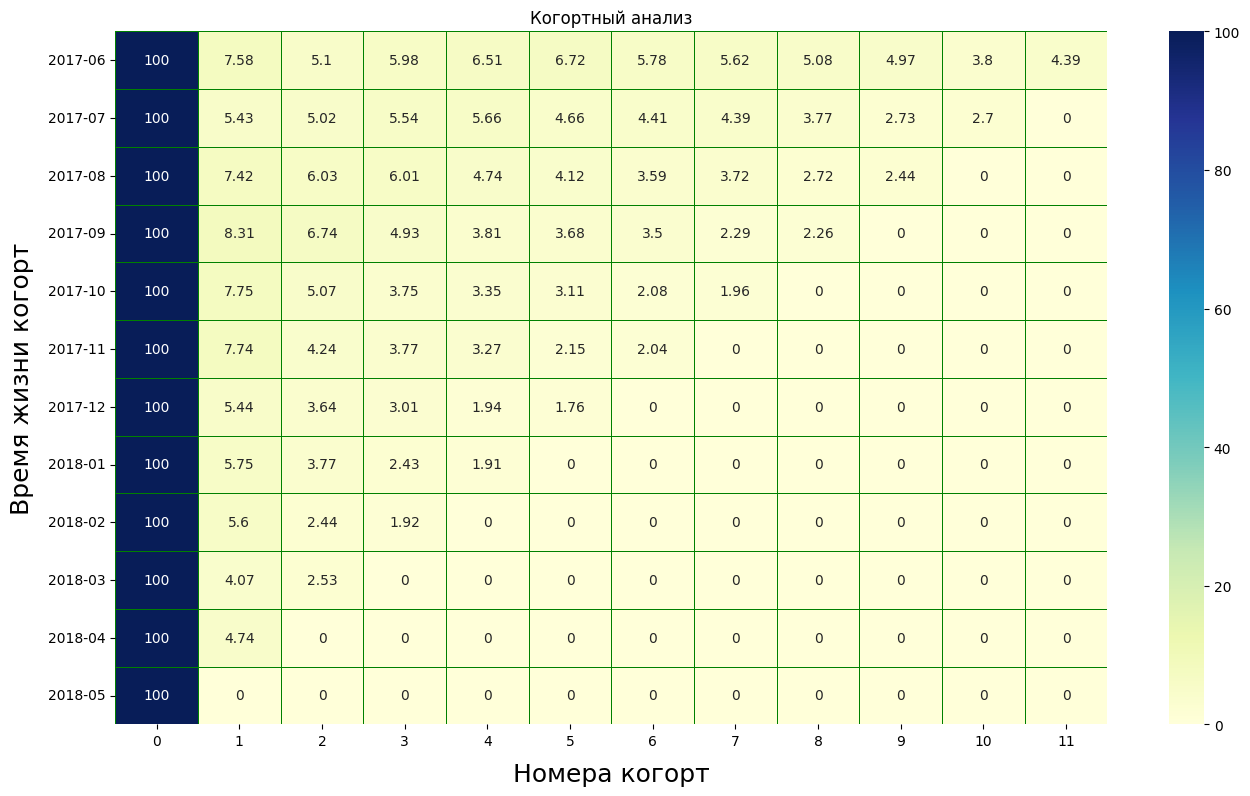

In [78]:
plt.figure(figsize = (16, 9))
plt.title('Когортный анализ')
ax = sns.heatmap(rr, annot=True, linecolor='green', linewidths=.5, cmap="YlGnBu", fmt='g')
ax.set_xlabel("Номера когорт", fontsize=18, labelpad=10)
ax.set_ylabel("Время жизни когорт", fontsize=18, labelpad=10)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.show()

In [81]:
rr.reset_index()

cohort_lifetime,cohort_name,0,1,2,3,4,5,6,7,8,9,10,11
0,2017-06,100.0,7.58,5.10,5.98,6.51,6.72,5.78,5.62,5.08,4.97,3.8,4.39
1,2017-07,100.0,5.43,5.02,5.54,5.66,4.66,4.41,4.39,3.77,2.73,2.7,0.00
2,2017-08,100.0,7.42,6.03,6.01,4.74,4.12,3.59,3.72,2.72,2.44,0.0,0.00
3,2017-09,100.0,8.31,6.74,4.93,3.81,3.68,3.50,2.29,2.26,0.00,0.0,0.00
4,2017-10,100.0,7.75,5.07,3.75,3.35,3.11,2.08,1.96,0.00,0.00,0.0,0.00
5,2017-11,100.0,7.74,4.24,3.77,3.27,2.15,2.04,0.00,0.00,0.00,0.0,0.00
6,2017-12,100.0,5.44,3.64,3.01,1.94,1.76,0.00,0.00,0.00,0.00,0.0,0.00
7,2018-01,100.0,5.75,3.77,2.43,1.91,0.00,0.00,0.00,0.00,0.00,0.0,0.00
8,2018-02,100.0,5.60,2.44,1.92,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00
9,2018-03,100.0,4.07,2.53,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00


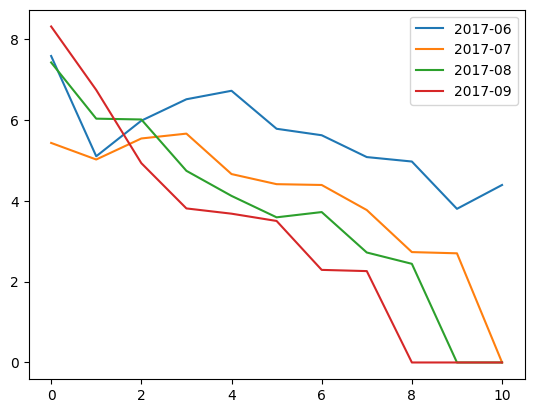

In [82]:
rr.reset_index()
for cohort in list(range(0,4)):
    x = list(range(0,11))
    y = rr.reset_index().loc[cohort, ["cohort_name", 1,2,3,4,5,6,7,8,9,10,11]].to_list()
    sns.lineplot(x=x, y=y[1:], label=y[0])
    plt.legend()

**Вывод: Первая когорта выделяется по сравнению с остальными**